In [1]:
from collections import Counter
import pandas as pd
import string
from transformers import AutoTokenizer, AutoConfig
import spacy
import codecs
import random
import pickle

/mnt2/wisniewski/nazanin/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text.lower() in pos_dict and not token.pos_ in pos_dict[token.text.lower()]:
                pos_dict[token.text.lower()].append(token.pos_)
            else:
                pos_dict[token.text.lower()] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['token', 'POS'])

### Creating wordbank file

In [126]:
with open('sample_data/wikitext/wikitext103_test.txt', 'r') as file:
    words = file.read().split()

df = pd.DataFrame(list(Counter(word.lower() for word in words).items()), columns=['token', 'count']).sort_values('count', ascending=False)
df = df[df['token'].apply(lambda t: t.isascii() and t  not in string.punctuation and not t.isdigit())].reset_index(drop=True)
df

,token,count
0,the,16057
1,of,6750
2,and,5793
3,in,5074
4,to,4766
...,...,...
17742,slick,1
17743,roadways,1
17744,icicles,1
17745,chandeliers,1


In [129]:
# only keeping words that are considered one token by the language model
tokenizer = AutoTokenizer.from_pretrained('google/multiberts-seed_0')
filtered_words = [word for word in df['token'].tolist() if len(tokenizer.tokenize(word)) == 1]
filtered_df = df[df['token'].isin(filtered_words)].reset_index(drop=True)

print(f'Percentage of words that are considered one token by the language model: {((len(filtered_df) / len(df)) * 100):.2f}%')

filtered_df['token_ids'] = filtered_df['token'].apply(lambda t: tokenizer.convert_tokens_to_ids(t))
filtered_df = filtered_df[['token', 'token_ids', 'count']]
filtered_df

Percentage of words that are considered one token by the language model: 64.79%


,token,token_ids,count
0,the,1996,16057
1,of,1997,6750
2,and,1998,5793
3,in,1999,5074
4,to,2000,4766
...,...,...,...
11493,immortal,12147,1
11494,maria,3814,1
11495,staggering,26233,1
11496,melee,27868,1


In [88]:
document = "sample_data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,token,POS
0,,[SPACE]
1,robert,[PROPN]
2,boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
18746,parlayed,[VERB]
18747,credibility,[NOUN]
18748,ronnie,[PROPN]
18749,pelkey,[PROPN]


In [130]:
merged_df = pd.merge(filtered_df, pos_tags, on='token', how='inner').sort_values(['token']).reset_index(drop=True)
merged_df

,token,token_ids,count,POS
0,100th,16919,2,[ADJ]
1,10th,6049,10,"[ADJ, PROPN]"
2,11th,6252,8,"[NOUN, ADJ]"
3,12th,5940,5,[NOUN]
4,13th,6122,7,[ADJ]
...,...,...,...,...
11491,zone,4224,21,[NOUN]
11492,zones,10019,6,[NOUN]
11493,zoo,9201,2,"[PROPN, NOUN]"
11494,zoom,24095,1,[NOUN]


In [131]:
merged_df.to_csv('sample_data/wikitext/wikitext_wordbank.tsv', sep='\t', index=None)

---

<Axes: title={'center': 'Distribution of token counts'}>

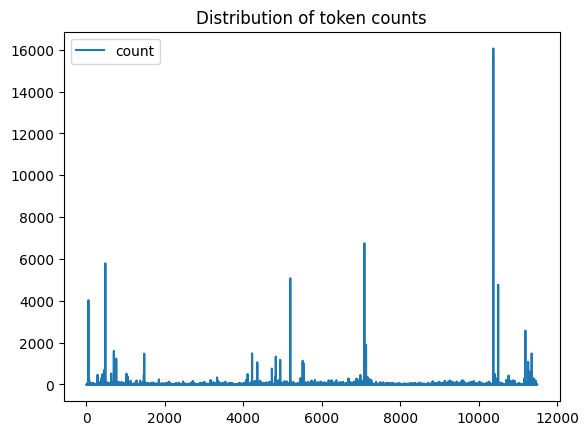

In [151]:
wordbank = pd.read_csv('sample_data/wikitext/wikitext_wordbank.tsv', sep='\t').dropna().reset_index(drop=True)
wordbank.plot(y='count', title='Distribution of token counts')

In [135]:
highly_frequent = wordbank[wordbank['count'].apply(lambda x: x > 512)]
print(f'{(len(wordbank)-len(highly_frequent))/len(wordbank)*100:.2f}% of tokens had a maximum of 512 samples in the dataset.')
highly_frequent

99.78% of tokens had a maximum of 512 samples in the dataset.


,token,token_ids,count,POS
55,a,1037,4030,['DET']
466,an,2019,719,['DET']
486,and,1998,5793,['CCONJ']
634,are,2024,524,['AUX']
703,as,2004,1605,['ADP']
765,at,2012,1238,['ADP']
1026,be,2022,519,['AUX']
1478,by,2011,1477,['ADP']
4227,for,2005,1488,['ADP']
4360,from,2013,1059,['ADP']


In [152]:
import stopwords

stop_words = set(stopwords.get_stopwords('english'))
stopwords_subset = highly_frequent[highly_frequent['token'].isin(stop_words)]

print(f'Number of words with more than 512 samples: {len(highly_frequent)}')
print(f'{len(stopwords_subset)/len(highly_frequent)*100}% of the words with more than 512 samples were English stopwords.')

Number of words with more than 512 samples: 25
100.0% of the words with more than 512 samples were English stopwords.


In [153]:
def get_sample_sentences(tokenizer, wordbank_file, tokenized_examples_file,
                         max_seq_len, min_seq_len, max_samples, bidirectional=True):
    short_sents = []
    num_long_sents = 0
    num_lines = 0
    # Each entry of token data is a tuple of token, token_id, masked_sample_sentences.
    token_data = []
    # Load words.
    df = pd.read_csv(wordbank_file, sep='\t').dropna().reset_index(drop=True)
    wordbank_tokens = df.token.unique().tolist()
    # Get token ids.
    for token in wordbank_tokens:
        token_id = tokenizer.convert_tokens_to_ids(token)
        if token_id != tokenizer.unk_token_id:
            token_data.append(tuple([token, token_id, []]))
    # Load sentences.
    print(f"Loading sentences from {tokenized_examples_file}.")
    infile = codecs.open(tokenized_examples_file, 'rb', encoding='utf-8')
    for line_count, line in enumerate(infile):
        num_lines += 1
        if line_count % 100000 == 0:
            print("Finished line {}.".format(line_count))
        example_string = line.strip()
        example = [int(token_id) for token_id in example_string.split()]
        # Use the pair of sentences (instead of individual sentences), to have
        # longer sequences. Also more similar to training.
        if len(example) < min_seq_len:
            short_sents.append(example)
            continue
        if len(example) > max_seq_len:
            num_long_sents += 1
            example = example[:max_seq_len]
        for token, token_id, sample_sents in token_data:
            if len(sample_sents) >= max_samples:
                # This token already has enough sentences.
                continue
            token_indices = [index for index, curr_id in enumerate(example) if curr_id == token_id]
            # Warning: in bidirectional contexts, the mask can be in the first or last position,
            # which can cause no mask prediction to be made for the biLSTM.
            if not bidirectional:
                # The token must have enough unidirectional context.
                # The sequence length (including the target token) must be at least min_seq_len.
                token_indices = [index for index in token_indices if index >= min_seq_len-1]
            if len(token_indices) > 0:
                new_example = example.copy()
                mask_idx = random.choice(token_indices)
                new_example[mask_idx] = tokenizer.mask_token_id
                sample_sents.append(new_example)
    infile.close()
    # Logging.
    print(f'{len(short_sents)} examples were shorter than {min_seq_len} tokens and were thus disregarded. {((num_lines-len(short_sents))/num_lines)*100:.2f}% of examples were kept.')
    print(f'{num_long_sents} examples were longer than {max_seq_len} tokens and were thus clipped.')
    return token_data, short_sents

In [154]:
wordbank_file = 'sample_data/wikitext/wikitext_wordbank.tsv'
tokenized_examples_file = 'sample_data/wikitext/test_tokenized.txt'
config = AutoConfig.from_pretrained('google/multiberts-seed_0')
max_seq_len = config.max_position_embeddings
min_seq_len = 8
max_samples = 512

token_data, short_sents = get_sample_sentences(
    tokenizer, wordbank_file, tokenized_examples_file, max_seq_len, min_seq_len, max_samples
    )

/mnt2/wisniewski/nazanin/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading sentences from sample_data/wikitext/test_tokenized.txt.
Finished line 0.
6 examples were shorter than 8 tokens and were thus disregarded. 99.45% of examples were kept.
60 examples were longer than 512 tokens and were thus clipped.


In [97]:
len(token_data)

11496

In [102]:
with open('sample_data/wikitext/bidirectional_samples_large.pickle', 'rb') as f:
    samples = pd.DataFrame(pickle.load(f), columns=['token', 'token_id', 'sample_sents']).sort_values('token').reset_index(drop=True)

samples

,token,token_id,sample_sents
0,0,1014,"[[101, 1996, 2034, 21327, 2328, 2005, 1996, 91..."
1,00,4002,"[[101, 2348, 2027, 2018, 2439, 3967, 2076, 199..."
2,000,2199,"[[101, 1000, 3610, 2017, 1000, 2003, 1037, 229..."
3,001,25604,"[[101, 1996, 3719, 2018, 1037, 3091, 1997, 185..."
4,01,5890,"[[101, 11811, 3487, 17710, 2869, 14238, 1006, ..."
...,...,...,...
9881,→,1585,"[[101, 23060, 16103, 14615, 10586, 2024, 7783,..."
9882,−,1597,"[[101, 1996, 4376, 3429, 1030, 1011, 1030, 102..."
9883,♯,1628,"[[101, 1000, 3610, 2017, 1000, 2003, 2019, 203..."
9884,東,1879,"[[101, 3707, 20464, 19303, 2020, 2036, 2109, 2..."


In [103]:
samples = samples[samples['token'].apply(lambda w: w.isascii() and not w.isdigit())]
samples

,token,token_id,sample_sents
18,100th,16919,"[[101, 17710, 2869, 14238, 2081, 2010, 3587, 3..."
27,10th,6049,"[[101, 2174, 1010, 2004, 5112, 3964, 1010, 200..."
38,11th,6252,"[[101, 2174, 1010, 2004, 5112, 3964, 1010, 200..."
50,12th,5940,"[[101, 2006, 2337, 1021, 1010, 2262, 1010, 177..."
60,13th,6122,"[[101, 4241, 11865, 1005, 1055, 4623, 2038, 20..."
...,...,...,...
9854,zone,4224,"[[101, 2006, 2257, 2322, 1010, 1996, 2167, 475..."
9855,zones,10019,"[[101, 1996, 3036, 6987, 2333, 2000, 5323, 103..."
9856,zoo,9201,"[[101, 9011, 4240, 2004, 1996, 4075, 1997, 199..."
9857,zoom,24095,"[[101, 2686, 2100, 2001, 27916, 1005, 2034, 36..."


In [104]:
final = samples[samples['sample_sents'].apply(lambda x: len(x) == 0)]
final

,token,token_id,sample_sents
685,accomplishment,24718,[]
727,activated,8878,[]
786,adorned,19189,[]
999,announces,17472,[]
1017,antiquity,16433,[]
1481,bidding,17534,[]
1626,breakers,24742,[]
2009,clandestine,24450,[]
2034,clearer,24509,[]
2414,consumers,10390,[]


In [105]:
print(f"{len(final)/len(samples)*100:.2f}% of tokens had no examples and were skipped.")

0.58% of tokens had no examples and were skipped.


In [149]:
with open(tokenized_examples_file, 'r') as file:
    corpus_token_ids = set(file.read().split())

corpus_token_ids = [int(id) for id in corpus_token_ids]
final[~final['token_id'].isin(corpus_token_ids)]

,token,token_id,sample_sents
2606,credibility,21553,[]


In [146]:
len(corpus_token_ids)

15878

In [147]:
wordbank[~wordbank['token_ids'].isin(corpus_token_ids)]

,token,token_ids,count,POS
2529,credibility,21553,1,['NOUN']
3979,fatty,19101,1,['PROPN']
8875,ronnie,11688,1,['PROPN']
